# 국민청원 데이터로 청원 카테고리 분류하기

* 청원의 카테고리를 분류해 봅니다.

In [145]:
import pandas as pd
import numpy as np
import re
print(pd.__version__)
print(np.__version__)
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'NanumGothic'

0.23.0
1.14.3


# 데이터 로드하기

In [840]:
# 크롤링해 온 국민청원 데이터를 판다스를 통해 읽어옵니다.
petitions = pd.read_csv('C:\dateGirls\TWL\jy617lee\petition.csv', parse_dates=['start', 'end'])
# 데이터의 크기가 어느정도인지 봅니다.
petitions.shape

(223453, 8)

In [841]:
petitions.describe()

,article_id,answered,votes
count,223453.000000,223453.000000,223453.000000
mean,135351.832493,0.000121,149.778132
std,84872.976221,0.010992,4626.610982
min,21.000000,0.000000,0.000000
25%,58270.000000,0.000000,1.000000
50%,134007.000000,0.000000,3.000000
75%,207608.000000,0.000000,11.000000
max,289322.000000,1.000000,714875.000000


In [842]:
# 전체 데이터 중 투표가 1000건 이상인 데이터를 기준으로 가져옵니다. 아웃라이어 데이터 제거를 위해 10만건 이상 데이터도 제거합니다.
df = petitions.loc[(petitions['votes'] > 100) & (petitions['votes'] < 25000)].copy()
df.shape

(9875, 8)

In [843]:
df.describe()

,article_id,answered,votes
count,9875.000000,9875.0,9875.000000
mean,167582.850127,0.0,1039.937013
std,75423.060164,0.0,2624.420555
min,28.000000,0.0,101.000000
25%,115222.500000,0.0,146.000000
50%,180903.000000,0.0,242.000000
75%,222646.000000,0.0,620.500000
max,289310.000000,0.0,24979.000000


In [844]:
category_count = df['category'].value_counts()
category_count

정치개혁           1500
인권/성평등         1242
기타              979
육아/교육           805
안전/환경           805
문화/예술/체육/언론     723
보건복지            710
교통/건축/국토        640
행정              510
외교/통일/국방        478
경제민주화           458
일자리             366
반려동물            236
미래              205
저출산/고령화대책       108
성장동력             75
농산어촌             35
Name: category, dtype: int64

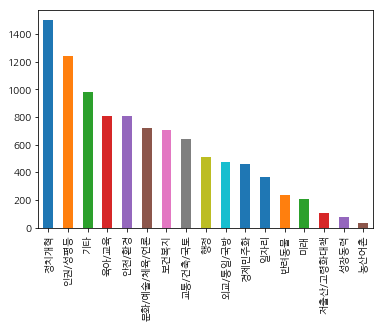

In [845]:
%matplotlib inline 
category_count.plot(kind='bar')

In [846]:
# 예측값과 실제값 비교를 위해 컬럼을 하나 더 생성합니다.
df['category_pred'] = df['category'].copy()

In [847]:
df.head(1)

,article_id,start,end,answered,votes,category,title,content,category_pred
7,28,2017-08-19,2017-08-26,0,2137,경제민주화,소액주주를 보호해주십시오,** 존경하옵는 문재인대통령님께\n저는 중국원양자원이라는 KOSPI상장사의 소액 ...,경제민주화


In [848]:
# 첫 번째 인덱스를 가져와 봅니다.
sample_index = df.iloc[0][0]
sample_index

28

In [849]:
sample_title = df['title'][sample_index]
sample_title

'치과위생사 국가고시 날짜 변경 억울합니다'

In [850]:
sample_content = petitions['content'][sample_index]
sample_content

'안녕하십니까? 대통령님 간단하게 제소개 부터 하겠습니다. 저는 치위생과 3학년 학생입니다. 다름이 아니라 너무 억울한\\n일이 생겨  이렇게 글을 적어봅니다. 저희 3학년들은 올해 아주 중요한 시험이  있었습니다.3년동안 힘들게 고생하여 이제곧\\n끝난다.조금만 힘을내자 라는 생각으로 견뎌내고 있었는데 갑자기 어제 과 단톡방의  이내용이 사실이냐면서 한장의 사진을\\n보내주었습니다. 그사진은 국시원에서 올린 공지글을 캡쳐한 사진이였습니다.국시원에서 국가고시 날짜가 변경 되었다.\\n그러니 이글을  널리퍼트려줘라라는 의미를 가진 내용이였습니다. 그내용을 읽고 너무 황당하고 어이가 없어서 국시원쪽으로 전화를 해보니 자신들은 어쩔수없었다 나라에서 그날 공무원 시험을 봐야한다 하루의 2번 국시를 볼수없다\\n그래서 자신들과 보건복지부에서  다시 날짜를 정했는데 그날이 내년 18년 1월 5일이다 라는것입니다.\\n그 말을  듣고 더욱 이해할수가 없었습니다. 먼저 그날 시험을 보기로한 국시생은 저희였는데 갑자기 아무런 말도 문자도\\n없고 그공지글도 그냥 통보였습니다. 국가에서보는 시험이 일반 초중고 수행평가도 아니고 갑자기 이런식으로  바뀐다는게\\n말이 됩니까? 고등학생들이 보는 모의고사,수능도 이런식으로  변경 하지않습니다.  통보로 날짜를 변경하는건  저희\\n에비 의료기사들을 무시하는걸로 보입니다. 저희학교 교수님들은 학생들에게 자부심을 가져라 치과위생사라는 직업을 아끼고 사랑하고 자부심을 가져도 되는 직업이니깐  당당 해져도 괜찮다고  말씀하셨습니다. 하지만 저는  그러지 못할꺼같습니다.  아마 저뿐만이아니라 마음 학생들도 자존심도 낮아지고 무시받는다고 생각했을것입니다.\\n17년 12월16일날의 시험을 봐야하는  국시생들은 저희 예비 치과위생사들 입니다. 공무원 시험이 갑자기 잡혀서  봐야한다면 다른날로 정하는게 맞지않을까요? 먼저 그날의 시험을 보기로 한 학생들은 저희입니다\\n왜 갑자기 저희가 양보해야하고  피해를봐야합니까?  저희국시 앞으로 4달남은상

# 전처리 하기 

In [851]:
def preprocessing(text):
    # 개행문자 제거
    text= str(text)
    text = re.sub('\\\\n', ' ', text)
    # 특수문자 제거
    # 특수문자나 이모티콘 등은 때로는 의미를 갖기도 하지만 여기에서는 제거했습니다.
    # text = re.sub('[?.,;:|\)*~`’!^\-_+<>@\#$%&-=#}※]', '', text)
    # 한글, 영문, 숫자만 남기고 모두 제거하도록 합니다.
    # text = re.sub('[^가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z0-9]', ' ', text)
    # 한글, 영문만 남기고 모두 제거하도록 합니다.
    text = re.sub('[^가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z]', ' ', text)
    return text

In [852]:
# 불용어 제거
def remove_stopwords(text):
    tokens = text.split(' ')
    stops = ['수', '현', '있는', '있습니다', '그', '년도', '합니다', '하는', '및', '제', '할', '하고', '더', '대한', '한', '그리고', '월', '저는', '없는', '입니다', '등', '일', '많은', '이런', '것은', '왜','같은', '같습니다', '없습니다', '위해', '한다']
    meaningful_words = [w for w in tokens if not w in stops]
    return ' '.join(meaningful_words)

In [853]:
# 샘플데이터에 적용
pre_sample_content = preprocessing(sample_content)

In [854]:
pre_sample_content = remove_stopwords(pre_sample_content)

In [855]:
pre_sample_content

'안녕하십니까  대통령님 간단하게 제소개 부터 하겠습니다  저는 치위생과  학년 학생입니다  다름이 아니라 너무 억울한 일이 생겨  이렇게 글을 적어봅니다  저희  학년들은 올해 아주 중요한 시험이  있었습니다  년동안 힘들게 고생하여 이제곧 끝난다 조금만 힘을내자 라는 생각으로 견뎌내고 있었는데 갑자기 어제 과 단톡방의  이내용이 사실이냐면서 한장의 사진을 보내주었습니다  그사진은 국시원에서 올린 공지글을 캡쳐한 사진이였습니다 국시원에서 국가고시 날짜가 변경 되었다  그러니 이글을  널리퍼트려줘라라는 의미를 가진 내용이였습니다  그내용을 읽고 너무 황당하고 어이가 없어서 국시원쪽으로 전화를 해보니 자신들은 어쩔수없었다 나라에서 그날 공무원 시험을 봐야한다 하루의  번 국시를 볼수없다 그래서 자신들과 보건복지부에서  다시 날짜를 정했는데 그날이 내년   년  월  일이다 라는것입니다  그 말을  듣고 더욱 이해할수가 없었습니다  먼저 그날 시험을 보기로한 국시생은 저희였는데 갑자기 아무런 말도 문자도 없고 그공지글도 그냥 통보였습니다  국가에서보는 시험이 일반 초중고 수행평가도 아니고 갑자기 이런식으로  바뀐다는게 말이 됩니까  고등학생들이 보는 모의고사 수능도 이런식으로  변경 하지않습니다   통보로 날짜를 변경하는건  저희 에비 의료기사들을 무시하는걸로 보입니다  저희학교 교수님들은 학생들에게 자부심을 가져라 치과위생사라는 직업을 아끼고 사랑하고 자부심을 가져도 되는 직업이니깐  당당 해져도 괜찮다고  말씀하셨습니다  하지만 저는  그러지 못할꺼같습니다   아마 저뿐만이아니라 마음 학생들도 자존심도 낮아지고 무시받는다고 생각했을것입니다    년   월  일날의 시험을 봐야하는  국시생들은 저희 예비 치과위생사들 입니다  공무원 시험이 갑자기 잡혀서  봐야한다면 다른날로 정하는게 맞지않을까요  먼저 그날의 시험을 보기로 한 학생들은 저희입니다 왜 갑자기 저희가 양보해야하고  피해를봐야합니까   저희국시 앞으로  달남은상태였고 지금 많은 학생들이 지쳐지만   

In [856]:
%time df['content_preprocessing'] = df['content'].apply(preprocessing)

Wall time: 1.27 s


In [857]:
%time df['content_preprocessing2'] = df['content_preprocessing'].apply(remove_stopwords)

Wall time: 650 ms


# 학습세트와 테스트세트 만들기
* 학습세트와 테스트세트를 7:3의 비율로 나눠 줍니다.

In [858]:
df = df.reindex()

In [859]:
df.shape

(9875, 11)

In [860]:
split_count = int(df.shape[0] * 0.7)
split_count

6912

In [861]:
# # 카테고리별로 7:3으로 나누기!

# df_train = pd.DataFrame()
# df_test = pd.DataFrame()
# # 1. 카테고리별로 테이블을 나눈다
# df_economy = df[df['category_pred']=='경제민주화']
# df_child = df[df['category_pred']=='육아/교육']
# df_job = df[df['category_pred']=='일자리']
# df_welfare = df[df['category_pred']=='보건복지']
# df_official = df[df['category_pred']=='행정']
# df_traffic = df[df['category_pred']=='교통/건축/국토']
# df_etc = df[df['category_pred']=='기타']
# df_art = df[df['category_pred']=='문화/예술/체육/언론']
# df_politics = df[df['category_pred']=='정치개혁']
# # df_equal = df[df['category_pred']=='인권/성평등']
# df_safe = df[df['category_pred']=='안전/환경']
# df_army = df[df['category_pred']=='외교/통일/국방']
# df_grow = df[df['category_pred']=='성장동력']
# df_future = df[df['category_pred']=='미래']
# df_dog = df[df['category_pred']=='반려동물']
# df_farm = df[df['category_pred']=='농산어촌']

# df_arr = [
#     df_economy, df_child, df_job, df_welfare, df_official, df_official, df_traffic,
#     df_etc, df_art, df_politics, df_equal, df_safe, df_army, df_grow,
#     df_future, df_dog, df_farm
# ]

# for one_df in df_arr :
#     split_count = int(one_df.shape[0] * 0.7)
#     train = one_df[:split_count].copy()
#     test = one_df[split_count:].copy()
#     df_train = df_train.append(train)
#     df_test = df_test.append(test)
# print(df_train.shape)
# print(df_test.shape)
df = df[df['category_pred']!='기타']

In [862]:
df_train = df[:split_count].copy()
df_train.shape

(6912, 11)

In [863]:
df_train.head(1)

,article_id,start,end,answered,votes,category,title,content,category_pred,content_preprocessing,content_preprocessing2
7,28,2017-08-19,2017-08-26,0,2137,경제민주화,소액주주를 보호해주십시오,** 존경하옵는 문재인대통령님께\n저는 중국원양자원이라는 KOSPI상장사의 소액 ...,경제민주화,존경하옵는 문재인대통령님께 저는 중국원양자원이라는 KOSPI상장사의 소액 주...,존경하옵는 문재인대통령님께 저는 중국원양자원이라는 KOSPI상장사의 소액 주...


In [864]:
df_test = df[split_count:].copy()
df_test.shape

(1984, 11)

In [865]:
df_test.head(1)

,article_id,start,end,answered,votes,category,title,content,category_pred,content_preprocessing,content_preprocessing2
183203,229756,2018-05-10,2018-06-09,0,572,안전/환경,대도심 지하터널(도로/철도)의 화려함과 그늘,전국적으로 대도심의 지하 40~100미터 지하도로와 광역철도를 공사 진행 및 공사계...,안전/환경,전국적으로 대도심의 지하 미터 지하도로와 광역철도를 공사 진행 및 공사계...,전국적으로 대도심의 지하 미터 지하도로와 광역철도를 공사 진행 및 공사계...


## 카테고리 

In [866]:
df_train_category_value = pd.DataFrame(df_train['category'].value_counts())
df_train_category_percent = pd.DataFrame(df_train['category'].value_counts(normalize=True))
df_train_category_value.merge(df_train_category_percent, left_index=True, right_index=True)

,category_x,category_y
정치개혁,1071,0.154948
인권/성평등,955,0.138166
육아/교육,647,0.093605
문화/예술/체육/언론,629,0.091001
안전/환경,599,0.086661
보건복지,586,0.084780
교통/건축/국토,528,0.076389
행정,402,0.058160
경제민주화,386,0.055845
외교/통일/국방,322,0.046586


In [867]:
df_test_category_value = pd.DataFrame(df_test['category'].value_counts())
df_test_category_percent = pd.DataFrame(df_test['category'].value_counts(normalize=True))
df_test_category_value.merge(df_test_category_percent, left_index=True, right_index=True)

,category_x,category_y
정치개혁,429,0.216230
인권/성평등,287,0.144657
안전/환경,206,0.103831
육아/교육,158,0.079637
외교/통일/국방,156,0.078629
보건복지,124,0.062500
교통/건축/국토,112,0.056452
행정,108,0.054435
문화/예술/체육/언론,94,0.047379
반려동물,80,0.040323


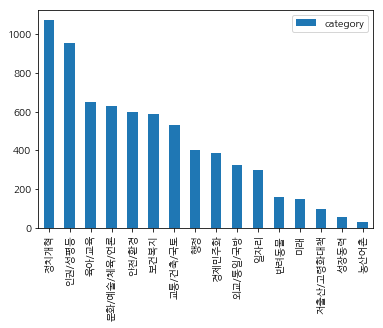

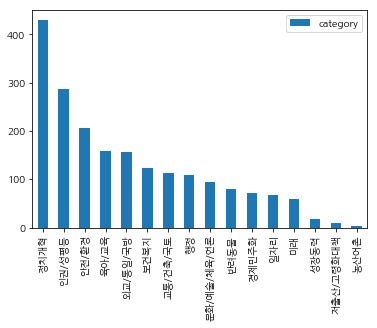

In [868]:
df_train_category_value.plot(kind='bar')
df_test_category_value.plot(kind='bar')

# 단어 벡터화 하기

In [869]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(analyzer = 'word', # 캐릭터 단위로 벡터화 할 수도 있습니다.
                             tokenizer = None, # 토크나이저를 따로 지정해 줄 수도 있습니다.
                             preprocessor = None, # 전처리 도구
                             stop_words = None, # 불용어 nltk등의 도구를 사용할 수도 있습니다.
                             min_df = 2, # 토큰이 나타날 최소 문서 개수로 오타나 자주 나오지 않는 특수한 전문용어 제거에 좋다. 
                             ngram_range=(1, 3), # BOW의 단위를 1~3개로 지정합니다.
                             max_features = 10000 # 만들 피처의 수, 단어의 수가 된다.
                            )
vectorizer

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=10000, min_df=2,
        ngram_range=(1, 3), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [870]:
%%time 
train_feature_vector = vectorizer.fit_transform(df_train['content_preprocessing2'])
train_feature_vector.shape

Wall time: 20.8 s


In [871]:
%%time 
test_feature_vector = vectorizer.fit_transform(df_test['content_preprocessing2'])
test_feature_vector.shape

Wall time: 5.84 s


In [872]:
vocab = vectorizer.get_feature_names()
print(len(vocab))
vocab[:10]

10000


['aid',
 'akr',
 'akr html',
 'anewsa',
 'anewsa com',
 'anewsa com detail',
 'article',
 'article html',
 'articles',
 'articleview']

In [873]:
from sklearn.feature_extraction.text import TfidfTransformer
transformer = TfidfTransformer(smooth_idf=False)
transformer

TfidfTransformer(norm='l2', smooth_idf=False, sublinear_tf=False,
         use_idf=True)

In [874]:
dist = np.sum(train_feature_vector, axis=0)

pd.DataFrame(dist, columns=vocab)

,aid,akr,akr html,anewsa,anewsa com,anewsa com detail,article,article html,articles,articleview,...,힘들지만,힘듭니다,힘쓰고,힘없고,힘없는,힘으로,힘을,힘을 모아,힘이,힘이 듭니다
0,29,21,21,97,23,22,21,159,23,63,...,22,77,87,21,22,120,41,191,120,17


In [875]:
%%time 
train_feature_tfidf = transformer.fit_transform(train_feature_vector)
train_feature_tfidf.shape

Wall time: 51 ms


In [876]:
%%time 
test_feature_tfidf = transformer.fit_transform(test_feature_vector)
test_feature_tfidf.shape

Wall time: 15 ms


In [877]:
test_feature_tfidf.shape

(1984, 10000)

# 랜덤 포레스트로 학습시키기
* 공식문서 : http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [878]:
from sklearn.ensemble import RandomForestClassifier

# 랜덤포레스트 분류기를 사용
forest = RandomForestClassifier(
    n_estimators = 100, n_jobs = -1, random_state=2018)
forest

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=2018, verbose=0,
            warm_start=False)

In [879]:
# 학습에 사용할 y_label 을 넣어줍니다.
# 어떤 분야의 청원인지 예측할 것이기 때문에 category를 넣어줍니다.
y_label = df_train['category']
%time forest = forest.fit(train_feature_tfidf, y_label)

Wall time: 13.1 s


# 학습이 잘 되었는지 평가하기

시험공부에 비유해 보면, (feat.애란쌤)
1. 기출문제를 모은다
2. 공부한다
3. 시험본다

여기에서 2번 단계를 하는 여러 전략이 있을텐데요, 기출문제를 모두 외워버리면 과연 내가 실제 시험을 잘 치룰 수 있을지 아니면 공부를 더 해야할지 판단하기가 애매합니다. 괜찮은 전략 중 하나는 기출문제 중 일부를 임의로 뽑아내서 공부하고(training set을 이용한 학습), 나머지 기출문제를 풀어보며 내가 얼마나 잘 푸는지 평가를 해보는겁니다(validation set을 통해 학습의 성과를 검증). 잘 된다 싶으면 시험을 볼 준비가 된 것입니다(실전 투입).


기출문제를 몽땅 외우면 기출문제 내에서는 100점을 받겠지만(overfitting), 실전에서도 그러한 성적을 가두리라 기대하기 어렵습니다.

In [880]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
k_fold = KFold(n_splits=5, shuffle=True, random_state=0)

scoring = 'accuracy'
%time score = cross_val_score(forest, train_feature_vector, y_label, cv=k_fold, n_jobs=-1, scoring=scoring)
score

Wall time: 50 s


array([0.48590022, 0.48011569, 0.5130246 , 0.47178003, 0.47467438])

In [881]:
round(np.mean(score)*100,2)

48.51

# 예측

In [882]:
# 테스트 데이터를 넣고 예측합니다.
y_pred = forest.predict(test_feature_vector)
y_pred[:3]

array(['인권/성평등', '정치개혁', '육아/교육'], dtype=object)

In [883]:
y_pred.shape

(1984,)

In [884]:
# 예측 결과를 저장하기 위해 데이터프레임에 담아 줍니다.
output = pd.DataFrame(data={'category_pred':y_pred})
output.head()

,category_pred
0,인권/성평등
1,정치개혁
2,육아/교육
3,정치개혁
4,안전/환경


In [885]:
# 0과 1이 어떻게 집계 되었는지 확인합니다.
# 실제 데이터에는 답변 대상 건이 있는데 없는 것으로 예측되었
output['category_pred'].value_counts()

정치개혁           831
육아/교육          263
문화/예술/체육/언론    211
인권/성평등         211
교통/건축/국토       120
보건복지            74
반려동물            73
경제민주화           66
안전/환경           52
행정              37
일자리             23
외교/통일/국방        17
저출산/고령화대책        4
성장동력             1
미래               1
Name: category_pred, dtype: int64

In [886]:
df_test['category_pred'] = y_pred

In [887]:
df_test['pred_diff'] = 0
df_test['pred_diff'] = (df_test['category'] == df_test['category_pred'] ) == 1
df_test['pred_diff'] = df_test['pred_diff'].astype(int)
df_test.head(1)

,article_id,start,end,answered,votes,category,title,content,category_pred,content_preprocessing,content_preprocessing2,pred_diff
183203,229756,2018-05-10,2018-06-09,0,572,안전/환경,대도심 지하터널(도로/철도)의 화려함과 그늘,전국적으로 대도심의 지하 40~100미터 지하도로와 광역철도를 공사 진행 및 공사계...,인권/성평등,전국적으로 대도심의 지하 미터 지하도로와 광역철도를 공사 진행 및 공사계...,전국적으로 대도심의 지하 미터 지하도로와 광역철도를 공사 진행 및 공사계...,0


In [888]:
# 맞게 예측한 청원은 1, 틀린 예측은 0으로 표기되었습니다.
pred_diff = df_test['pred_diff'].value_counts()
pred_diff

0    1654
1     330
Name: pred_diff, dtype: int64

In [889]:
print('전체 {}건의 데이터 중 {}건 예측'.format(y_pred.shape[0], pred_diff[1]))

전체 1984건의 데이터 중 330건 예측


In [890]:
acc = ( pred_diff[1] / y_pred.shape[0] )*100 
print('예측 비율 {}'.format(acc))

예측 비율 16.633064516129032


In [891]:
# 제대로 예측한 카테고리 데이터를 봅니다.
predict_correct = df_test.loc[df_test['pred_diff'] == 1]
predict_correct['category'].value_counts()

정치개혁           217
육아/교육           38
인권/성평등          23
보건복지            17
교통/건축/국토        10
경제민주화            9
문화/예술/체육/언론      7
안전/환경            3
일자리              3
반려동물             2
외교/통일/국방         1
Name: category, dtype: int64

In [892]:
predict_incorrect = df_test.loc[df_test['pred_diff'] == 0].copy()
predict_incorrect['category'].value_counts()

인권/성평등         264
정치개혁           212
안전/환경          203
외교/통일/국방       155
육아/교육          120
행정             108
보건복지           107
교통/건축/국토       102
문화/예술/체육/언론     87
반려동물            78
일자리             64
경제민주화           63
미래              59
성장동력            18
저출산/고령화대책       10
농산어촌             4
Name: category, dtype: int64

In [893]:
predict_incorrect_value = predict_incorrect['category'].value_counts()
predict_incorrect_value

인권/성평등         264
정치개혁           212
안전/환경          203
외교/통일/국방       155
육아/교육          120
행정             108
보건복지           107
교통/건축/국토       102
문화/예술/체육/언론     87
반려동물            78
일자리             64
경제민주화           63
미래              59
성장동력            18
저출산/고령화대책       10
농산어촌             4
Name: category, dtype: int64

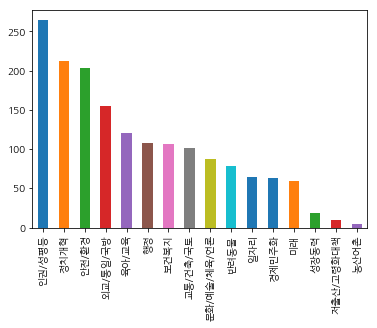

In [894]:
# 잘못 예측한 카테고리 중 인권/성평등 카테고리가 가장 많습니다.
predict_incorrect_value.plot(kind='bar')

# 왜 예측의 정확도가 낮을까요?
* 청원을 입력하는 사람마다 카테고리 분류 기준이 정확하지 않은 것 같습니다.
* 기타로 예측한 분류도 특정 카테고리로 분류해도 될 것으로 보여집니다.

In [895]:
predict_incorrect[['category', 'category_pred', 'title', 'content']]

,category,category_pred,title,content
183203,안전/환경,인권/성평등,대도심 지하터널(도로/철도)의 화려함과 그늘,전국적으로 대도심의 지하 40~100미터 지하도로와 광역철도를 공사 진행 및 공사계...
183225,인권/성평등,정치개혁,혜경궁 김씨 진실을 밝혀주세요..,"저는 평범한 시민이자, 민주당 지지자입니다.\n그동안 김대중 대통령님,노무현 대통령..."
183236,교통/건축/국토,육아/교육,국민들의 주거환경을 위협하는 LH 이제는 정말 쇄신해야 합니다. LH 공공 아파트 ...,LH는 국민의 주거생활 향상 및 국토의 효율적 이용을 도모해 국민 경제 발전에 이바...
183242,안전/환경,정치개혁,강동구 둔촌주공아파트 재건축 관련하여 동북중고등학교 학생들이 위험에 노출되어 있습니다.,강동구 둔촌주공아파트 재건축이 본격화 되면서 지하철9호선 공사와 맞물려 학생들의 안...
183263,육아/교육,안전/환경,보여주기식 어린이집 평가인증제 제발 없애주세요!!!,어린이집 평가인증제 제발 없애주세요!!!\n보육교사들은 자신의 자식보다 자신의 가족...
183286,보건복지,정치개혁,대마오일 약으로 처방받아 쓸수 있게 해주세요,의료용으로는 사용해도 된다고 생각합니다\n아이를 키우는 입장에서 저희 아이가 아파서...
183290,보건복지,문화/예술/체육/언론,"대마오일 사용하게 해주세요"" 뇌전증 환자, 마지막 희망","대마 밀수 혐의의 한 의사의 스토리였다.\n엄마는 ""2012년에 태어났는데 보통 3..."
183329,인권/성평등,안전/환경,북한식당 여종업원 기획 탈북 진상규명 및 관련 국정원 직원 처벌 청원,방금 전 <이규연의 스포트라이트>에서 방영한 내용에 대해 청원합니다.\n2016년 ...
183360,성장동력,경제민주화,서토덕(탈핵운동가)이 원자력연구원 상임감사를 한다구요? 그럼 원전수출 가능할까요?,대통령까지 나서 원전을 수출하려고 노력하고 있습니다.\n언제부터인가 각종 정부기관 ...
183365,반려동물,정치개혁,불법 개농장( 강아지 번식장) 철거를 청원합니다(꼭 봐주십쇼),러분 동물학대가 뭔지 아시나요?동물학대란?동물과 인간의 지속적인 행복 및 규정준수의...


## 원래 데이터 중 기타로 분류되었으나 분류기가 다르게 예측한 청원을 봅니다.

In [896]:
predict_incorrect_etc = predict_incorrect.loc[predict_incorrect['category'] == '기타'].copy()
predict_incorrect_etc[['category', 'category_pred', 'title', 'content']].head(10)
predict_incorrect_etc[['category', 'category_pred', 'title', 'content']]['category_pred'].value_counts()

Series([], Name: category_pred, dtype: int64)